## Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from collections import namedtuple
%matplotlib inline

In [2]:
# Remove this if you want to test neural activities. this is for reporducibility purpose
np.random.seed(19680801)
ranodm.seed(19680801)

NameError: name 'ranodm' is not defined

#### Optimizations for Matplotlib

In [3]:
import matplotlib as mpl
import matplotlib.style as mplstyle
mpl.rcParams['path.simplify'] = True
mpl.rcParams['path.simplify_threshold'] = 1.0
mpl.rcParams['agg.path.chunksize'] = 10000
mplstyle.use('fast')

### Leaky Integrate & Fire Model + Optimization

##### Neuron Dynamic: $\tau.\frac{du}{dt} = -(u - u_{rest}) + R.I(t)$


In [4]:
class LIF:
    __slots__ = ['dt__τ', 'θ', 'R', 'u_rest', 'u', 'input',  'spike_trace', 'isi', 'posts']
 
    def __init__(self, config: namedtuple):
        self.θ = config.threshold
        self.R = config.resistor
        self.u_rest = config.uRest
        self.dt__τ = config.dt / config.tau
        self.isi = int(config.isInhibitory)
        self.u = self.u_rest
        self.input = 0
        self.spike_trace = []
        self.posts = []
        
    def integrate(self, I, t):
        self.u += (self.u_rest - self.u + self.R * I) * (self.dt__τ)
        
        if self.u >= self.θ:
            self.u = self.u_rest
            self.spike_trace.append(t)
            
            # self.potential_list.append(self.θ)
            # self.potential_list.append(self.u)
            
            # update entry input for post synaptic neurons
            for synapse in self.posts:
                synapse.neuron.input += pow(-1,self.isi) * synapse.w * (self.θ - self.u_rest)
        
        self.u += self.input
        return int(t in self.spike_trace[-1:]) # if neuron has just spiked in time t return 1 otherwise 0       

### Neuron Populations


$\Delta t$ is a small time interval

##### Population Activity $A(t)$
$n_{act}(t, t + \Delta t)$ return number of spikes for population

$A(t) = \lim\limits_{\Delta t \to 0} \frac{n_{act}(t, t + \Delta t)}{\Delta t * N}$ in discrit mathematic we approximate to $\frac{\sum\limits_{j=1}^N \sum\limits_{f} \delta (t - t^f)}{N}$


In [5]:
class Population:
    def __init__(self, conf: namedtuple):
        self.size = conf.size
        
        # inhibitory neurons
        isi_size = int((1 - conf.splitSize) * self.size)
        self.neurons = [conf.neuron(conf.isiConfig) for _ in range(isi_size)]
       
        # exicitory neurons
        self.neurons.extend(
            [conf.neuron(conf.iseConfig) for _ in range(self.size - isi_size)]
        )
        
        self.α = conf.traceAlpha
        self.activities = []
        
    def activate(self, I, t):
        # count of spikes for all neurons with a generator        
        n_act = sum((neuron.integrate(I, t) for neuron in self.neurons))
        self.activities.append((t, n_act / self.size))
    
    def reset_inputs(self):
        for neuron in self.neurons:
            neuron.input = min(0, (1 - self.α) * neuron.input)
    
    def get_detailed_spikes(self):
        return np.array([
            [i, tf] for (i, neuron) in enumerate(self.neurons) for tf in neuron.spike_trace
        ])


#### Configuration (namedtuple)

lif:
+ tau : $\tau$
+ resistor: $R$
+ threshold: $\theta$
+ uRest: $u_{rest}$
+ dt: small interval of time to make dynamic equeation discrete
+ isInhibitory: falg showing a neuron is inhibitory or not 

synapse:
+ neuron: reference to post synaptic neuron (it can be from other populations)
+ w: connection weight

population:
+ size: size of population
+ splitSize: $pop = [(1-splitSize) * size] * neurons^{inhibitory} \cup [splitSize * size] * neurons^{excitatory}$
+ neuron: neuron model [LIF, ELIF, AELIF, ...]
+ isiConfig: configuration for inhibitory neurons 
+ iseConfig: configuration for excitatory neurons 
+ traceAlpha: $\alpha$ used in inputs reseting phase 

In [6]:
CONFIGS = {
    # neurons
    "lif": namedtuple('LIFConfig', 'tau resistor threshold uRest dt isInhibitory'),
    # connections
    "synapse": namedtuple('SynapseConfig', 'neuron w'),
    "connection": namedtuple('ConnectionTypeConfig', 'mu sigma coupling_probability'),
    # population
    "population": namedtuple('PopulationParams', 'size splitSize neuron isiConfig iseConfig traceAlpha'),
}

### Connectivities

```py
connect = connectivities[strategy]
connect(preSynapticPopulation, postSynapticPopulation, config:ConnectionTypeConfig)
```

In [7]:
Synapse = CONFIGS['synapse']

def full_connectivity(pre_neurons, post_neurons, config):
    μ, σ = config.mu, config.sigma    
    normal = np.random.normal

    for pre in pre_neurons:
        for post in post_neurons:
            pre.posts.append(Synapse(post, normal(μ, σ)))

            
def fixed_coupling_probability_connectivity(pre_neurons, post_neurons, config):
        C_pre_size = int(config.coupling_probability * len(pre_neurons))
        C_post_size = int(config.coupling_probability * len(post_neurons))

        μ, σ = config.mu, config.sigma    
        normal = np.random.normal

        for pre in np.random.choice(pre_neurons, C_pre_size, replace=False):
            pre.posts.extend([
                Synapse(post, normal(μ, σ)) for post in
                    np.random.choice(pre_neurons, C_post_size, replace=False)
            ])

            
def fixed_number_of_presynaptics_parents(pre_neurons, post_neurons, config):
    C = int(config.coupling_probability * len(pre_neurons))
    μ, σ = config.mu, config.sigma    
    normal = np.random.normal
    for post in post_neurons:
        for pre in np.random.choice(pre_neurons, C, replace=False):
            pre.posts.append(Synapse(post, normal(μ, σ)))

            
connectivities = {
    'full': full_connectivity,
    'fixedCP': fixed_coupling_probability_connectivity,
    'fixedNPP': fixed_number_of_presynaptics_parents,
}

### utitlites + Plotters

In [8]:
def noise(μ=0, σ=0.5):
    return np.random.normal(μ, σ)

In [9]:
def choice(*choices):
    return np.random.choice(choices)

In [10]:
class CurrentManager:
    def __init__(self, duration, dt, currents):
        self.time_intervals = np.arange(0, duration, dt)
        self.currents = currents(duration, dt) if callable(currents) else currents
    def __enter__(self):
        return zip(self.currents, self.time_intervals)
    def __exit__(self, type, value, traceback):
        del self.currents
        del self.time_intervals

In [11]:
def raster_plot(x, y, c):  
    plt.scatter(x, y, s=1, c=c)
    for (area,color,label) in [(20, 'y', 'inhibitory'), (80, 'm','excititory')]:
        plt.scatter([], [], c=color, alpha=0.8, s=area, label=label)
    plt.legend(scatterpoints=1, frameon=False, labelspacing=1)

    plt.title("raster plot")
    plt.ylabel("Neurons")
    plt.xlabel("times")
    plt.show()

### Setup

In [12]:
dt = 0.1
duration = 20
isi_config = CONFIGS['lif'](10+noise(0,2), 5, -60, -70, dt ,True)
ise_config =CONFIGS['lif'](10+noise(0,2), 5, -60, -70, dt ,False)

pop_config = CONFIGS['population'](1000, 0.8, LIF, isi_config, ise_config, 0.6)

In [13]:
def currentsCreator(duration, dt):
    _currents = [0 for _ in np.arange(0, 5, dt)]
    _currents.extend([np.random.uniform(2, 10) for _ in np.arange(5, duration-5, dt)])
    _currents.extend([0 for _ in np.arange(duration-5, duration, dt)])
    return _currents

#### Full Connection population 

In [14]:
pop = Population(pop_config)

connect = connectivities['full']
connection_configs = CONFIGS['connection'](0.2, 0.1, None)
connect(pop.neurons, pop.neurons, connection_configs)

#### Fixed coupling  population 

In [15]:
pop = Population(pop_config)

connect = connectivities['fixedCP']
connection_configs = CONFIGS['connection'](0.2, 0.1, 0.01)
connect(pop.neurons, pop.neurons, connection_configs)

#### Fixed number of presynaptics parents population 

In [16]:
pop = Population(pop_config)

connect = connectivities['fixedNPP']
connection_configs = CONFIGS['connection'](0.2, 0.1, 0.25)
connect(pop.neurons, pop.neurons, connection_configs)

#### Raster plot

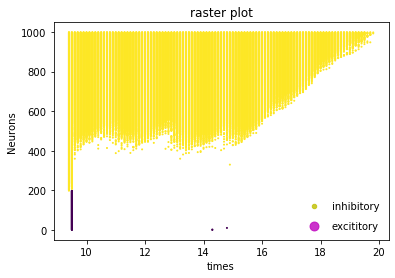

In [17]:
full_progress = False
with CurrentManager(duration, dt, currentsCreator) as currents:
    population_spikes = []
    for (I, t) in currents:
        pop.activate(I, t)
        pop.reset_inputs()
        population_spikes = pop.get_detailed_spikes()

        
        if (not full_progress or population_spikes.shape[0] == 0):
            continue
        c = [1 if pop.neurons[int(i[0])].isi else 3 for i in population_spikes]
        raster_plot(population_spikes[:, 1], population_spikes[:, 0], c)
    if (not full_progress):
        c = [1 if pop.neurons[int(i[0])].isi else 3 for i in population_spikes]
        raster_plot(population_spikes[:, 1], population_spikes[:, 0], c)

## Decision making

### Utils + Plotters

In [18]:
def aggregate_spikes(*detailed_spike_traces):
    spikes = None
    gap = 0
    for dst in detailed_spike_traces:
        if dst.shape[0] == 0:
            continue
        
        dst[:, 0] += gap
        if spikes is None:
            spikes = dst
        else:
            spikes = np.concatenate((spikes, dst), axis=0)
        gap += pop.size

    return np.array(spikes)

### decision Plot

In [19]:
def decision_plot(activity_1, activity_2):
    plt.plot(activity_1[:, 0], activity_1[:, 1], 'b', label="Population 1")
    plt.plot(activity_2[:, 0], activity_2[:, 1], 'c', label="Population 2")
    plt.title("Population Activities")
    plt.xlabel("time")
    plt.ylabel("Activity")
    plt.legend()
    plt.show()

### Setup

In [20]:
dt = 0.1
duration = 60
get_isi_config = lambda: CONFIGS['lif'](choice(8, 10, 12), choice(5, 8, 10)+noise(), choice(-60, -65, -50), choice(-70, -75), dt ,True)
get_ise_config = lambda: CONFIGS['lif'](choice(8, 10, 12), choice(5, 8, 10)+noise(), choice(-60, -65, -50), choice(-70, -75), dt ,False)

pop_A_config = CONFIGS['population'](400, 1, LIF, get_isi_config(), get_ise_config(), noise(0.5, 0.4))
pop_B_config = CONFIGS['population'](400, 1, LIF, get_isi_config(), get_ise_config(), noise(0.5, 0.4))
pop_C_config = CONFIGS['population'](200, 0, LIF, get_isi_config(), get_ise_config(), noise(0.5, 0.4))


In [21]:
def currentsCreator(duration, dt):
    # A pop currents
    _currents_A = [0 for _ in np.arange(0, 5, dt)]
    _currents_A.extend([np.random.uniform(2, 7) for _ in np.arange(5, duration-5, dt)])
    _currents_A.extend([0 for _ in np.arange(duration-5, duration, dt)])
    # B pop currents
    _currents_B = [0 for _ in np.arange(0, 5, dt)]
    _currents_B.extend([np.random.uniform(0, 1) for _ in np.arange(5, duration-5, dt)])
    _currents_B.extend([0 for _ in np.arange(duration-5, duration, dt)])
    # C pop currents
    _currents_C = [0 for _ in np.arange(0, 5, dt)]
    _currents_C.extend([np.random.uniform(2, 9) for _ in np.arange(5, duration-5, dt)])
    _currents_C.extend([0 for _ in np.arange(duration-5, duration, dt)])
    
    return zip(_currents_A, _currents_B, _currents_C)

In [22]:
pop_A = Population(pop_A_config)
pop_B = Population(pop_B_config)
pop_C = Population(pop_C_config)

# connections
connectCP = connectivities['fixedCP']
connectNNP = connectivities['fixedNPP']

get_connection_config = lambda: CONFIGS['connection'](abs(0.2+noise(0.1,0.2)), abs(0.1+noise(0.1,0.1)), abs(0.1+noise(0.2, 0.1)))

# recurrent
connectNNP(pop_A.neurons, pop_A.neurons, get_connection_config())
connectNNP(pop_B.neurons, pop_B.neurons, get_connection_config())
connectNNP(pop_C.neurons, pop_C.neurons, get_connection_config())

# cyclic
connectNNP(pop_A.neurons, pop_B.neurons, get_connection_config())
connectNNP(pop_B.neurons, pop_A.neurons, get_connection_config())

connectNNP(pop_A.neurons, pop_C.neurons, get_connection_config())
connectNNP(pop_C.neurons, pop_A.neurons, get_connection_config())

connectNNP(pop_B.neurons, pop_C.neurons, get_connection_config())
connectNNP(pop_C.neurons, pop_B.neurons, get_connection_config())

0.0/60
5.0/60
10.0/60
15.0/60
20.0/60
25.0/60
30.0/60
35.0/60
40.0/60
45.0/60
50.0/60
55.0/60


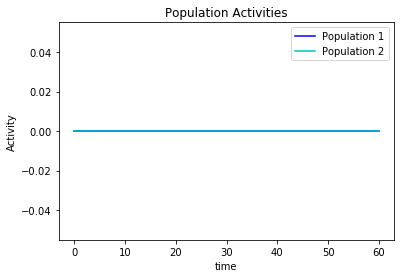

In [23]:
full_progress = False
with CurrentManager(duration, dt, currentsCreator) as currents:
    population_spikes = []
    for (I_A, I_B, I_C), t in currents:
        # activation
        pop_A.activate(I_A, t)
        pop_B.activate(I_B, t)
        pop_C.activate(I_C, t)
        # reseting
        pop_A.reset_inputs()
        pop_B.reset_inputs()
        pop_C.reset_inputs()
        
        if full_progress:
            population_spikes = aggregate_spikes(pop_A.get_detailed_spikes(), 
                                                 pop_A.get_detailed_spikes(), 
                                                 pop_C.get_detailed_spikes())
            
            
            """ raster plot """
            # c = [choice('m', 'y') for i in range(population_spikes.shape[0])]
            # raster_plot(population_spikes[:, 1], population_spikes[:, 0], c)
            """ descision plot """
            decision_plot(np.array(pop_A.activities), np.array(pop_B.activities))
        
        if (t % 5 == 0):
            print(f"{t}/{duration}")
            
    if not full_progress:
        # descision plot
        decision_plot(np.array(pop_A.activities), np.array(pop_B.activities))

## Documentation

### Terms and Norms

population size $N$ (Network with $N$ Neurons)

$\Delta t$ is a small time interval

### Population Activity $A(t)$
$n_{act}(t, t + \Delta t)$ return number of spikes for population

$A(t) = \lim\limits_{\Delta t \to 0} \frac{n_{act}(t, t + \Delta t)}{\Delta t * N}$ in discrit mathematic we approximate to $\frac{\sum\limits_{j=1}^N \sum\limits_{f} \delta (t - t^f)}{N}$

### Interaction population
The input cuurent to a neuron i in group $\Gamma_n$ is generated by the spikes of all its connected nuerons

$I_{i,n} = \sum\limits_j \sum\limits_f w_{ij} \alpha_{ij} (t - t_j^f)$

$I_n = I_{i,n} = \sum\limits_m J_{nm} \int_0^{\infty} \alpha(s) A_m(t - s)ds$


### Example: Homogeneous population of integrate-and-fire neurons

In the case of leaky integrate-and-fire neurons, encountered in Chapters 1 and 5 (Wulfram, Werner)

$\tau_m \frac{d}{dt}u_i = -u_i + RI_i(t) \text{ for } u_i \lt \theta$

combined with a reset condition: if $u_i \ge \theta$ then integration restarts at $u_{rest}$

A homogeneous network implies that all neurons have the same input resistance $R$, the same membrane
time constant $\tau_m$, as well as identical thresholds $\theta$ and reset values $u_{rest}$. 

$I_i =\sum\limits_{j=1}^N\sum_f w_{ij}\alpha(t −t_j^f) + I^{ext}(t)$


#### Competition through common inhibition

A network consisting of two excitatory populations interacting with
a common inhibitory population

Within the two excitatory populations neurons are randomly connected with "fixed number of presynaptics parents" & "fixed coupling probability connectivity" strategy.

Parameters and connection weights are adjusted to have
spontaneous activity at low firing rates

Competition through common inhibition
+ Consider a strong, but unbiased stimulus.
+ Immediately after the onset of stimulation, both excitatory populations increase their firing rates.
+ Soon afterward, one of the activities grows further and the other one is suppressed.
+ The population which develops a high activity is called the winner of the competition.